# 다른 전처리 방법 혹은 분석한거 이 파일에 공유해서 올려도되고 따로 노티해주세요😁
- moa mention : good job sungwoo

# import

In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer

import torch

from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Dacon/Data/발화자의 감정인식 AI

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dacon/Data/발화자의 감정인식 AI


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Dacon/Data/발화자의 감정인식 AI/"
SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
info = pd.read_csv('data_info.csv',encoding='euc-kr')
info

,feature,information,type
0,ID,고유번호,object
1,Utterance,발화문,object
2,Speaker,발화자,object
3,Dialogue_ID,Dialogue 구분 번호,int
4,Target,감정,object


In [ ]:
train

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise
...,...,...,...,...,...
9984,TRAIN_9984,You or me?,Chandler,1038,neutral
9985,TRAIN_9985,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,1038,neutral
9986,TRAIN_9986,"You guys are messing with me, right?",Joey,1038,surprise
9987,TRAIN_9987,Yeah.,All,1038,neutral


In [ ]:
test

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachell,0
2,TEST_0002,You know what?,Rachell,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joeyy,1
4,TEST_0004,To push!,Joeyy,1
...,...,...,...,...
2605,TEST_2605,"Yeah, I mean, go Ross, no one will even notice...",Rachell,279
2606,TEST_2606,They don't listen to me?,Rossi,279
2607,TEST_2607,"Of course, they listen to you! Everyone listen...",Rachell,279
2608,TEST_2608,"Monica, do you really think I should try this ...",Rossi,279


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           9989 non-null   object
 1   Utterance    9989 non-null   object
 2   Speaker      9989 non-null   object
 3   Dialogue_ID  9989 non-null   int64 
 4   Target       9989 non-null   object
dtypes: int64(1), object(4)
memory usage: 390.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2610 non-null   object
 1   Utterance    2610 non-null   object
 2   Speaker      2610 non-null   object
 3   Dialogue_ID  2610 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 81.7+ KB


In [ ]:
train.shape, test.shape

((9989, 5), (2610, 4))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


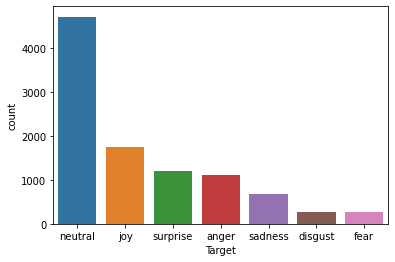

In [ ]:
import seaborn as sns
sns.countplot(train.Target, order = train.Target.value_counts().index)

# train, test의 Utterance 변형
- EmoBERTa 논문을 보니 입력 데이터를 "Speaker : Utterance" 식으로 만들어져있음
- 따라서 train, test의 'Speaker' column을 'Utterance'와 합쳐봄

In [ ]:
speak = train['Speaker'].tolist()
text = train['Utterance'].tolist()

conv_text = []

for i in range(len(train)):
  conv_text.append(speak[i] + " : "+ text[i])

train['Utterance'] = conv_text

In [ ]:
speak = test['Speaker'].tolist()
text = test['Utterance'].tolist()

conv_text = []

for i in range(len(test)):
  conv_text.append(speak[i] + " : "+ text[i])

test['Utterance'] = conv_text

# Label encoding

In [ ]:
train['labels'] = train['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})

In [ ]:
train['Dialogue_ID'] = train['Dialogue_ID'].astype('category')
test['Dialogue_ID'] = test['Dialogue_ID'].astype('category')
train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target,labels
0,TRAIN_0000,Chandler : also I was the point person on my c...,Chandler,0,neutral,0
1,TRAIN_0001,The Interviewer : You must’ve had your hands f...,The Interviewer,0,neutral,0
2,TRAIN_0002,Chandler : That I did. That I did.,Chandler,0,neutral,0
3,TRAIN_0003,The Interviewer : So let’s talk a little bit a...,The Interviewer,0,neutral,0
4,TRAIN_0004,Chandler : My duties? All right.,Chandler,0,surprise,2


In [ ]:
test.head()

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Mark : Why do all the coffee cups have figures...,Mark,0
1,TEST_0001,Rachell : Oh. It's so Monica can follow. Of th...,Rachel,0
2,TEST_0002,Rachell : You know what?,Rachel,0
3,TEST_0003,"Joeyy : Come on, Lydia, you can do it.",Joey,1
4,TEST_0004,Joeyy : To push!,Joey,1


# Utterance 분석

In [ ]:
# default: !,? 등의 문장 부호까지 제거
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Utterance'])
# train에 존재하는 단어 수

len(tokenizer.word_index)

5991

# 정수 인코딩

In [ ]:
X_train = tokenizer.texts_to_sequences(train['Utterance'])
X_test = tokenizer.texts_to_sequences(test['Utterance'])

# X_train, X_test 결측치 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(len(drop_train), len(drop_test))

0 81


In [ ]:
# test에 존재하는 빈 리스트로 인코딩된 문장 확인
for i in drop_test:
    print(i, test['Utterance'][i])

30 Mornica : Quoi?
62 Rossi : Bumpys
111 Mornica : Oui.
200 Chadler : Hé!
205 Mornica : Quoi?
270 Chadler : Quoi?
381 Rachell : Quoi?
395 Rachell : Diane Keaton.
423 Chadler : Hé!
444 Chadler : Hé!
456 Joeyy : Hé!
489 Rossi : Quoi?!
511 Mornica : Gin.
517 Chadler : Hé!
518 Mornica : Hé!
550 Rossi : Hé!
565 Joeyy : Quoi?!
601 Rachell : Quoi?
616 Rossi : Merci.
622 Joeyy : Hein?
793 Rachell : Arghh !!
834 Joeyy : Merci!
846 Chadler : «Kay?
906 Mornica : Hose.
919 Rossi : Hé!
920 Joeyy : Hose.
944 Rossi : Quoi?
992 Mornica : Quoi?!
1015 Chadler : Quoi?
1141 Joeyy : Hose.
1146 Joeyy : Bonjour?
1153 Joeyy : Canceled?!
1189 Brenda : Quoi?
1222 Joeyy : Hé!
1242 Joeyy : Mains!
1246 Joeyy : 816, merci!
1273 Rachell : Oui!
1278 Joeyy : Hé!
1279 Rachell : Hé!
1284 Chadler : Mec!Mec!
1295 Mornica : Quoi?!
1312 Rossi : Hein?
1334 Chadler : Quoi?
1336 Chadler : Quoi?!
1351 Mornica : Stuart!
1374 Chadler : Exclude!!
1487 Joeyy : Hé!
1504 Rossi : Ahhhh !!
1513 Rossi : Hé!
1570 Rossi : Diverse
1647 Rac

# 프랑스어? 스페인어? 가 존재함;
---

# Speaker 분석
## train 데이터에서 압도적으로 많이 등장하는 인물은 6명 `Joey, Ross, Rachel, Phoebe, Monica, Chandler` 
## 6명의 이름을 통해 대화 데이터인 것을 알 수 있었음

- test 데이터를 보면 역시 6명이 많이 등장하는데, 이름이 train에서와 조금씩 다름(알파벳 1글자씩 다름) 
- test의 대화에서는 train의 인물과 동일한 것을 보아 이 이름들을 추후 train과 일치시켜줘야 할 필요가 있어보임

In [ ]:
test['Speaker'].value_counts().head(10)

Joeyy       411
Chadler     379
Rossi       373
Rachell     356
Mornica     346
Phoebe      291
Janice       31
Emily        16
Director     16
Gunther      13
Name: Speaker, dtype: int64

In [ ]:
for _ in tqdm(range(len(test))):
    test['Speaker'].replace('Joeyy', 'Joey', inplace=True)
    test['Speaker'].replace('Chadler', 'Chandler', inplace=True)
    test['Speaker'].replace('Rossi', 'Ross', inplace=True)
    test['Speaker'].replace('Rachell', 'Rachel', inplace=True)
    test['Speaker'].replace('Mornica', 'Monica', inplace=True)

  0%|          | 0/2610 [00:00<?, ?it/s]

In [ ]:
test['Speaker'].value_counts().head(10)

Joey        411
Chandler    379
Ross        373
Rachel      356
Monica      346
Phoebe      291
Janice       31
Emily        16
Director     16
Gunther      13
Name: Speaker, dtype: int64

In [ ]:
train

,ID,Utterance,Speaker,Dialogue_ID,Target,labels
0,TRAIN_0000,Chandler : also I was the point person on my c...,Chandler,0,neutral,0
1,TRAIN_0001,The Interviewer : You must’ve had your hands f...,The Interviewer,0,neutral,0
2,TRAIN_0002,Chandler : That I did. That I did.,Chandler,0,neutral,0
3,TRAIN_0003,The Interviewer : So let’s talk a little bit a...,The Interviewer,0,neutral,0
4,TRAIN_0004,Chandler : My duties? All right.,Chandler,0,surprise,2
...,...,...,...,...,...,...
9984,TRAIN_9984,Chandler : You or me?,Chandler,1038,neutral,0
9985,TRAIN_9985,"Ross : I got it. Uh, Joey, women don't have Ad...",Ross,1038,neutral,0
9986,TRAIN_9986,"Joey : You guys are messing with me, right?",Joey,1038,surprise,2
9987,TRAIN_9987,All : Yeah.,All,1038,neutral,0


In [ ]:
test

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Mark : Why do all the coffee cups have figures...,Mark,0
1,TEST_0001,Rachell : Oh. It's so Monica can follow. Of th...,Rachel,0
2,TEST_0002,Rachell : You know what?,Rachel,0
3,TEST_0003,"Joeyy : Come on, Lydia, you can do it.",Joey,1
4,TEST_0004,Joeyy : To push!,Joey,1
...,...,...,...,...
2605,TEST_2605,"Rachell : Yeah, I mean, go Ross, no one will e...",Rachel,279
2606,TEST_2606,Rossi : They don't listen to me?,Ross,279
2607,TEST_2607,"Rachell : Of course, they listen to you! Every...",Rachel,279
2608,TEST_2608,"Rossi : Monica, do you really think I should t...",Ross,279


# 허모아 데이터증강 코드 공유 

### 유의어/반대어 대체 함수 
- 타겟 클래스 별로 비율을 다르게 해서 데이터 증강할 예정인데, 이 부분은 더 고민해봐야할 것 같습니다

In [ ]:
# nltk download
import nltk
# Open Multilingual Wordnet ("OMW") 
nltk.download('omw-1.4')
# wordnet download
nltk.download('wordnet')
# from nltk.corpus import wordnet

- 유의어 , 반대어 둘 다 활용

In [ ]:
# design1
def text_replace(word):
  synonyms , antonyms = list(), list()
  for syn in wordnet.synsets(word):
    for lemm in syn.lemmas():
      synonyms.append(lemm.name())
      if lemm.antonyms():
        antonyms.append(lemm.antonyms()[0].name())
  return  synonyms[0] if synonyms[0] != word  else ( antonyms[0] if len(antonyms) != 0  else word) 

- 유의어만 활용

In [ ]:
def get_deduple_val(synonymsList, compare_word):
  # set을 쓰기 때문에 굳이 random할 수 있도록 조작해줄 필요없음
  for word in set(synonymsList):
    if word!= compare_word:
      result  = word
      break
  return result

- 유의어 변경함수

In [ ]:
# 유의어 변경 함수
def change(token):
  if not wordnet.synsets(token)[0].lemmas()[0].name() : 
    result = token 
  else : result = wordnet.synsets(token)[0].lemmas()[0].name() 
  return result
# pass List 지정안하면 에러발생
passList = ['’', '.', '!', '?', '!!', '!?']
def changeAll(data):
  resultData = list()
  for sentenceList in data:
    sent = [change(token) for token, pos in nltk.tag.pos_tag(sentenceList) if pos.startswith('NN') and (token not in passList)]
    resultData.append(sent)
  return resultData  